In [1]:
# Data Collection & Preprocessing
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


tickers = ['JPM', 'BAC']
data = yf.download(tickers, start="2018-01-01", end="2021-12-31", auto_adjust=False)['Adj Close']
data.dropna(inplace=True)


[*********************100%***********************]  2 of 2 completed


In [2]:
import pandas as pd
import statsmodels.api as sm

def rolling_hedge_ratio(x, y, window=60):

    ratios = []
    for i in range(window, len(x)):
        x_window = x.iloc[i - window:i]
        y_window = y.iloc[i - window:i]
        model = sm.OLS(x_window, sm.add_constant(y_window))
        res = model.fit()
        ratios.append(res.params.iloc[1])  # Use .iloc to avoid FutureWarning
    return pd.Series(ratios, index=x.index[window:])

# Compute rolling hedge ratio between JPM and BAC
rolling_beta = rolling_hedge_ratio(data['JPM'], data['BAC'], window=60)

# Align both series to hedge ratio index
bac_rolled = data['BAC'].reindex(rolling_beta.index)
jpm_rolled = data['JPM'].reindex(rolling_beta.index)

# Calculate rolling spread
spread = jpm_rolled - rolling_beta * bac_rolled


In [4]:
!pip install pykalman


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.5/145.5 kB 9.6 MB/s eta 0:00:00


In [5]:
#Kalman Filter Smoothing
from pykalman import KalmanFilter

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, n_dim_state=1)
state_means, _ = kf.filter(spread.values)
smoothed_spread = pd.Series(state_means.flatten(), index=spread.index)


In [6]:
!pip install hmmlearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 8.2 MB/s eta 0:00:00


In [7]:
# Volatility Regime Detection with HMM
from hmmlearn.hmm import GaussianHMM

log_ret = np.log(spread / spread.shift(1)).dropna()
vol = log_ret.rolling(window=20).std().dropna().values.reshape(-1, 1)

hmm = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000)
hmm.fit(vol)
hidden_states = hmm.predict(vol)


regimes = pd.Series(np.nan, index=spread.index)
regimes.iloc[-len(hidden_states):] = hidden_states

# Final feature DF
features = pd.DataFrame(index=spread.index)
features['Spread'] = spread
features['Smoothed'] = smoothed_spread
features['Regime'] = regimes


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
# LSTM Forecasting of Smoothed Spread
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lookback = 10
scaler = MinMaxScaler()
scaled = scaler.fit_transform(features['Smoothed'].values.reshape(-1, 1))

X, y = [], []
for i in range(lookback, len(scaled)):
    X.append(scaled[i-lookback:i])
    y.append(scaled[i])
X, y = np.array(X), np.array(y)

X = X.reshape((X.shape[0], X.shape[1], 1))

# Build LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, epochs=10, batch_size=32, verbose=1)

# Predict
predicted = model.predict(X)
predicted = scaler.inverse_transform(predicted)
predicted_series = pd.Series(predicted.flatten(), index=features.index[lookback:])


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1283
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0071
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0051
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [9]:
# Compute z-score of spread
z_score = (spread - spread.rolling(60).mean()) / spread.rolling(60).std()

# Entry and exit
signals = pd.Series(0, index=z_score.index)
signals[z_score > 1] = -1   # Short JPM / Long BAC
signals[z_score < -1] = 1   # Long JPM / Short BAC
signals[(z_score > -0.5) & (z_score < 0.5)] = 0  # Exit zone

# Carry forward position until exit
signals = signals.ffill().fillna(0)


<ipython-input-10-98581467>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  beta_aligned = rolling_beta.reindex(signals.index).fillna(method='ffill')


Sharpe Ratio: 0.87
Value at Risk (95% confidence): -4.83%
CAGR: 42.50%
Total Return: 278.22%


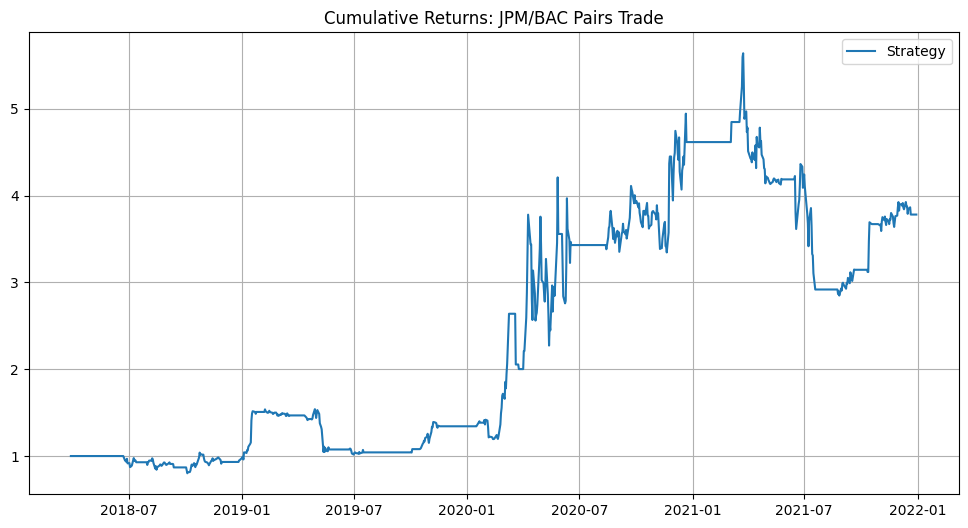

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Align returns and hedge ratio
returns = data[['JPM', 'BAC']].pct_change().reindex(signals.index).fillna(0)
beta_aligned = rolling_beta.reindex(signals.index).fillna(method='ffill')

# Construct positions based on signals
positions = pd.DataFrame(index=signals.index)
positions['JPM'] = -signals
positions['BAC'] = signals * beta_aligned

strategy_returns = (positions.shift(1) * returns).sum(axis=1)

# Cumulative return
cumulative_returns = (1 + strategy_returns).cumprod()

# Sharpe Ratio (annualized)
sharpe = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)

# Value at Risk (VaR) at 95% confidence
var_95 = np.percentile(strategy_returns, 5)

# CAGR
n_years = (strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25
cagr = cumulative_returns.iloc[-1]**(1 / n_years) - 1

# Total return
total_return = cumulative_returns.iloc[-1] - 1

print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Value at Risk (95% confidence): {var_95:.2%}")
print(f"CAGR: {cagr:.2%}")
print(f"Total Return: {total_return:.2%}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Strategy')
plt.title('Cumulative Returns: JPM/BAC Pairs Trade')
plt.grid(True)
plt.legend()
plt.show()
